# Bifurcation V–I panels and continuation markers
**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.



Baseline parameters: {'alpha0': 1.0, 'kappa': 0.0, 'beta0': -0.4, 'chi0': 0.05, 'a0': 1.0, 'mu0': 0.15, 'b0': 2, 'gamma0': 0.0, 'vrest0': 0.0}


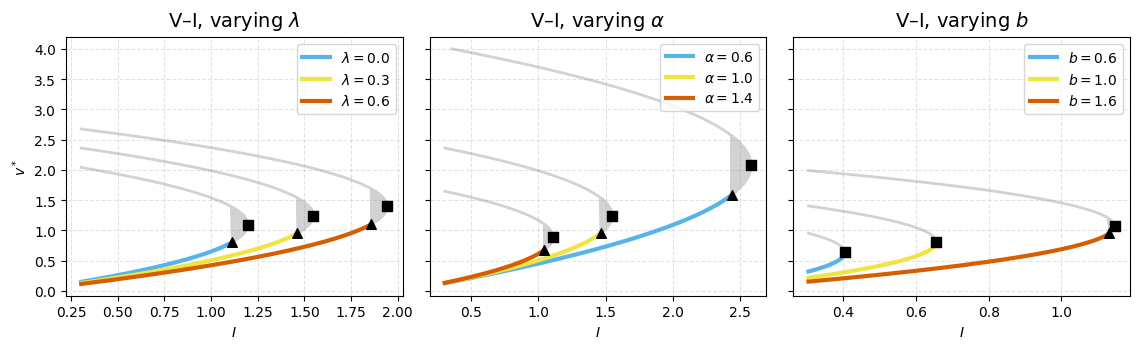

Saved: /content/outputs/VI_bifurcation_panels.png

Continuation markers table (markers may lie outside prior fixed window):
       Panel  lambda  alpha   b  I_SN  v_SN   I_H   v_H
lambda sweep     0.0    1.0 2.0 1.198 1.095 1.111 0.800
lambda sweep     0.3    1.0 2.0 1.549 1.245 1.462 0.950
lambda sweep     0.6    1.0 2.0 1.945 1.395 1.858 1.100
 alpha sweep     0.3    0.6 2.0 2.582 2.074 2.437 1.583
 alpha sweep     0.3    1.0 2.0 1.549 1.245 1.462 0.950
 alpha sweep     0.3    1.4 2.0 1.106 0.889 1.044 0.679
     b sweep     0.3    1.0 0.6 0.404 0.636   NaN   NaN
     b sweep     0.3    1.0 1.0 0.656 0.810   NaN   NaN
     b sweep     0.3    1.0 1.6 1.146 1.071 1.132 0.950

Saved: /content/outputs/VI_markers_table.csv

LaTeX written to /content/outputs/VI_markers_table.tex


In [ ]:
# %% panels with SN (■) and Hopf (▲) markers.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
from pathlib import Path
CWD0 = Path.cwd()
REPO_ROOT = (CWD0.parent if CWD0.name.lower() == "notebooks" else CWD0)
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

try:
    from src.nos import NOSParams, f_sat as f_sat_vec, f_sat_prime as f_sat_prime_vec
except Exception:
    from nos import NOSParams, f_sat as f_sat_vec, f_sat_prime as f_sat_prime_vec
try:
    from src.linearisation import LinPoint, effective_dbar
except Exception:
    from linearisation import LinPoint, effective_dbar


OUT_DIR = REPO_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ===== Baseline parameters ========
alpha0 = 1.0
kappa  = 0.0           # 0 => quadratic small-signal; >0 => saturation
beta0  = -0.40
chi0   = 0.05
a0, mu0 = 1.0, 0.15
b0     = 2          # baseline b; Hopf requires ab>(a+mu)^2 => b>1.44 with these a,mu
gamma0 = 0.0
vrest0 = 0.0


USE_COMPACT_BASELINE = False
if USE_COMPACT_BASELINE:
    beta0 = 0.10
    b0    = 1.6


print('Baseline parameters:', dict(alpha0=alpha0, kappa=kappa, beta0=beta0, chi0=chi0, a0=a0, mu0=mu0, b0=b0, gamma0=gamma0, vrest0=vrest0))

# Record baseline as NOSParams
p_base = NOSParams(
    alpha=float(alpha0),
    kappa=float(kappa),
    beta=float(beta0),
    gamma=float(gamma0),
    lam=0.3,
    chi=float(chi0),
    v_rest=float(vrest0),
    a=float(a0),
    b=float(b0),
    mu=float(mu0),
)


# Panels and curves
lambda_vals = [0.0, 0.3, 0.6]
alpha_vals  = [0.6, 1.0, 1.4]
b_vals      = [0.6, 1.0, 1.6]     # include 1.6 so Hopf is admissible
panel_specs = [
    ("lambda", r"$\lambda$", lambda_vals),
    ("alpha",  r"$\alpha$",  alpha_vals),
    ("b",      r"$b$",       b_vals),
]
curve_colors = ['#56B4E9', '#F0E442', '#D55E00']

# Search grids
I_default = (-0.6, 0.7)            # used if AUTO_I_RANGE=False
AUTO_I_RANGE = True                # auto widen I-range to include all markers
I_grid_dense = 500                 # resolution of I sweep for branch plotting
v_search = (-2.0, 4.0)             # v-interval for saturated root scanning

# ===== Model nonlinearity and helpers =========
def f_sat(v, alpha, kappa):
    # Removed scalar wrapping, as f_sat_vec can handle array inputs
    return f_sat_vec(v, float(alpha), float(kappa))

def fprime_sat(v, alpha, kappa):
    # Removed scalar wrapping, as f_sat_prime_vec can handle array inputs
    return f_sat_prime_vec(v, float(alpha), float(kappa))


def eff_params(alpha, lam, b, beta=beta0, chi=chi0, a=a0, mu=mu0, gamma=gamma0, vrest=vrest0):
    L  = beta - lam - chi - (a*b)/(a+mu)
    C0 = gamma + chi*vrest
    return L, C0

def F(v, I, alpha, kappa, L, C0):
    return f_sat(v, alpha, kappa) + L*v + C0 + I

def is_stable(v, alpha, kappa, lam, b, beta=beta0, chi=chi0, a=a0, mu=mu0):
    p_loc = NOSParams(
        alpha=float(alpha), kappa=float(kappa),
        beta=float(beta), gamma=0.0,
        lam=float(lam), chi=float(chi), v_rest=float(vrest0),
        a=float(a), b=float(b), mu=float(mu),
    )
    lp = LinPoint(vstar=float(v), coupling_through_nonlinearity=False)
    dbar = float(effective_dbar(p_loc, lp))  # = f'(v*) + beta - lam - chi (paper proxy)
    T = dbar - (a + mu)
    Delta = (a * b) - dbar * (a + mu)
    return (T < 0.0) and (Delta > 0.0)

# ----- root scanning (robust, no scipy) --------
def bisection_root(g, a, b, args=(), tol=1e-8, maxit=60):
    fa, fb = g(a,*args), g(b,*args)
    if np.isnan(fa) or np.isnan(fb) or fa*fb > 0: return None
    lo, hi = a, b
    for _ in range(maxit):
        mid = 0.5*(lo+hi)
        fm = g(mid,*args)
        if np.isnan(fm): return None
        if abs(fm) < tol or abs(hi-lo) < tol: return mid
        if fa*fm <= 0: hi, fb = mid, fm
        else: lo, fa = mid, fm
    return 0.5*(lo+hi)

def scan_roots_1d(g, a, b, args=(), nscan=4000, tol=1e-8):
    xs = np.linspace(a, b, nscan+1)
    ys = g(xs,*args)
    roots=[]
    for i in range(nscan):
        y0,y1 = ys[i], ys[i+1]
        if np.isnan(y0) or np.isnan(y1): continue
        if y0 == 0.0:
            roots.append(xs[i]); continue
        if y0*y1 < 0.0:
            r = bisection_root(lambda x,*ar:g(x,*ar), xs[i], xs[i+1], args=args, tol=tol)
            if r is not None and (not roots or abs(r-roots[-1])>1e-5):
                roots.append(r)
    return roots

# -------- marker calculators -----
def SN_points(alpha, kappa, L, C0):
    if kappa == 0.0:
        v_sn = -L/(2*alpha); I_sn = (L*L)/(4*alpha) - C0
        return [(v_sn, I_sn)]
    roots = scan_roots_1d(lambda v,a,k,L_: fprime_sat(v,a,k)+L_, v_search[0], v_search[1],
                          args=(alpha,kappa,L))
    return [(v, -F(v,0.0,alpha,kappa,L,C0)) for v in roots]

def Hopf_candidates(alpha, kappa, lam, L, C0, beta=beta0, chi=chi0, a=a0, mu=mu0):
    if kappa == 0.0:
        v_h = ((a+mu) - (beta - lam - chi))/(2*alpha)
        I_h = -F(v_h, 0.0, alpha, kappa, L, C0)
        return [(v_h, I_h)]
    target = (a+mu) - (beta - lam - chi)
    roots = scan_roots_1d(lambda v,a,k,t: fprime_sat(v,a,k)-t, v_search[0], v_search[1],
                          args=(alpha,kappa,target))
    return [(v, -F(v,0.0,alpha,kappa,L,C0)) for v in roots]

def choose_rep(points):
    pts = [(v,I) for (v,I) in points if np.isfinite(I)]
    if not pts: return (np.nan, np.nan)
    # representative: closest to zero I (cosmetic choice for table)
    return min(pts, key=lambda t: abs(t[1]))

# ===== First pass: compute markers to set I-range if needed =======
rows = []
I_all_markers = []

for vary, _, vals in panel_specs:
    # choose panel baseline b; if you want Hopf in lambda/alpha panels, lift b
    panel_b0 = b0 if vary=="b" else max(b0, 1.6)  # ensure ab>(a+mu)^2 when desired
    for val in vals:
        alpha, lam, b = alpha0, 0.3, panel_b0
        if vary=="lambda": lam = val
        elif vary=="alpha": alpha = val
        else: b = val
        L, C0 = eff_params(alpha, lam, b)
        # SN
        sn = SN_points(alpha, kappa, L, C0)
        v_sn, I_sn = choose_rep(sn)
        # Hopf candidates; keep only those with Δ>0 at trace-zero (purely algebraic)
        Delta_trace = (a0*b) - (a0+mu0)**2  # Hopf admissible iff ab>(a+mu)^2
        hopfs = Hopf_candidates(alpha, kappa, lam, L, C0)
        hopf_valid = [(v,I) for (v,I) in hopfs if Delta_trace > 0]
        v_h, I_h = choose_rep(hopf_valid)
        for I_mark in [I_sn, I_h]:
            if np.isfinite(I_mark): I_all_markers.append(I_mark)
        rows.append({"Panel":f"{vary} sweep","lambda":lam,"alpha":alpha,"b":b,
                     "I_SN":I_sn,"v_SN":v_sn,"I_H":I_h,"v_H":v_h})

if AUTO_I_RANGE and I_all_markers:
    pad = 0.1
    I_min = min(I_all_markers) - pad
    I_max = max(I_all_markers) + pad
else:
    I_min, I_max = I_default

# ===== Second pass: plot with a range that shows markers =========
fig, axes = plt.subplots(1,3, figsize=(11.5,3.6), sharey=True)
for ax, (vary, vary_label, vals) in zip(axes, panel_specs):
    ax.set_title(fr"V–I, varying {vary_label}", fontsize=14, pad=8)
    panel_b0 = b0 if vary=="b" else max(b0, 1.6)  # keep Hopf admissible where desired
    for c, val in zip(curve_colors, vals):
        alpha, lam, b = alpha0, 0.3, panel_b0
        if vary=="lambda": lam = val; legend = fr'$\lambda={val:.1f}$'
        elif vary=="alpha": alpha = val; legend = fr'$\alpha={val:.1f}$'
        else: b = val;   legend = fr'$b={val:.1f}$'

        L, C0 = eff_params(alpha, lam, b)
        I_grid = np.linspace(I_min, I_max, I_grid_dense)

        v_st,I_st,v_un,I_un=[],[],[],[]
        for I in I_grid:
            roots = scan_roots_1d(lambda v: F(v,I,alpha,kappa,L,C0), v_search[0], v_search[1])
            for v in roots:
                if is_stable(v,alpha,kappa,lam,b):
                    v_st.append(v); I_st.append(I)
                else:
                    v_un.append(v); I_un.append(I)

        if I_st: ax.plot(I_st, v_st, color=c, lw=3.0, label=legend)
        if I_un: ax.plot(I_un, v_un, color='gray', lw=2.0, alpha=0.35)


        sn = SN_points(alpha, kappa, L, C0)
        v_sn, I_sn = choose_rep(sn)
        if np.isfinite(I_sn) and (I_min <= I_sn <= I_max):
            ax.scatter([I_sn],[v_sn], marker='s', s=48, color='k', zorder=5)

        Delta_trace = (a0*b) - (a0+mu0)**2  # Hopf admissible iff ab>(a+mu)^2
        if Delta_trace > 0:
            hopfs = Hopf_candidates(alpha, kappa, lam, L, C0)
            v_h, I_h = choose_rep(hopfs)
            if np.isfinite(I_h) and (I_min <= I_h <= I_max):
                ax.scatter([I_h],[v_h], marker='^', s=48, color='k', zorder=5)

    ax.set_xlabel(r'$I$')
    ax.grid(True, ls='--', alpha=0.35)
    ax.legend(frameon=True, fontsize=10, loc='upper right')

axes[0].set_ylabel(r'$v^*$')
fig.tight_layout()
fig.savefig(OUT_DIR / 'VI_bifurcation_panels.png', dpi=220)
plt.show()
print("Saved:", (OUT_DIR / 'VI_bifurcation_panels.png').as_posix())

# ========= Parameter provenance (public artefact hygiene) ===
import json as _json
params_used = dict(
    alpha0=float(alpha0), kappa=float(kappa), beta0=float(beta0), chi0=float(chi0),
    a0=float(a0), mu0=float(mu0), b0=float(b0), gamma0=float(gamma0), vrest0=float(vrest0),
    lambda_vals=lambda_vals, alpha_vals=alpha_vals, b_vals=b_vals,
    use_compact_baseline=bool(USE_COMPACT_BASELINE),
)
with open(OUT_DIR / "VI_params.json", "w", encoding="utf-8") as f:
    _json.dump(params_used, f, indent=2)

# === Continuation markers table =========
df = pd.DataFrame(rows, columns=["Panel","lambda","alpha","b","I_SN","v_SN","I_H","v_H"])
df = df.astype({"lambda":float,"alpha":float,"b":float,"I_SN":float,"v_SN":float,"I_H":float,"v_H":float})
print("\nContinuation markers table (markers may lie outside prior fixed window):")
print(df.round(3).to_string(index=False))
df.round(6).to_csv(OUT_DIR / "VI_markers_table.csv", index=False)
print("\nSaved:", (OUT_DIR / "VI_markers_table.csv").as_posix())

def df_to_latex(df, kappa_val):
    lines = []
    lines += [r"\begin{table}[t]",
              r"\centering",
              r"\caption{Continuation markers for the reduced system ($\kappa=%s$). "
              r"Entries list $I_{\mathrm{SN}}$, $I_{\mathrm{H}}$ and the corresponding equilibria "
              r"$v^*_{\mathrm{SN}}, v^*_{\mathrm{H}}$. Hopf requires $ab>(a+\mu)^2$.}" % f"{kappa_val:.1f}",
              r"\label{tab:VI_markers}",
              r"\begin{tabular}{lcccccccc}",
              r"\toprule",
              r"Panel & $\lambda$ & $\alpha$ & $b$ & $I_{\mathrm{SN}}$ & $v^*_{\mathrm{SN}}$ & $I_{\mathrm{H}}$ & $v^*_{\mathrm{H}}$ \\",
              r"\midrule"]
    for _,r in df.iterrows():
        def cell(x):
            return r"\text{--}" if (isinstance(x,float) and np.isnan(x)) else (f"{x:.3f}" if isinstance(x,float) else f"{x}")
        lines.append(f"{r['Panel']} & {r['lambda']:.1f} & {r['alpha']:.1f} & {r['b']:.1f} & "
                     f"{cell(r['I_SN'])} & {cell(r['v_SN'])} & {cell(r['I_H'])} & {cell(r['v_H'])} \\")
    lines += [r"\bottomrule", r"\end{tabular}", r"\end{table}"]
    return "\n".join(lines)

latex_tab = df_to_latex(df, kappa)
with open(OUT_DIR / "VI_markers_table.tex", "w", encoding="utf-8") as f:
    f.write(latex_tab)
print("\nLaTeX written to", (OUT_DIR / "VI_markers_table.tex").as_posix())